Shape of X: (100, 2)
Shape of y: (100,)


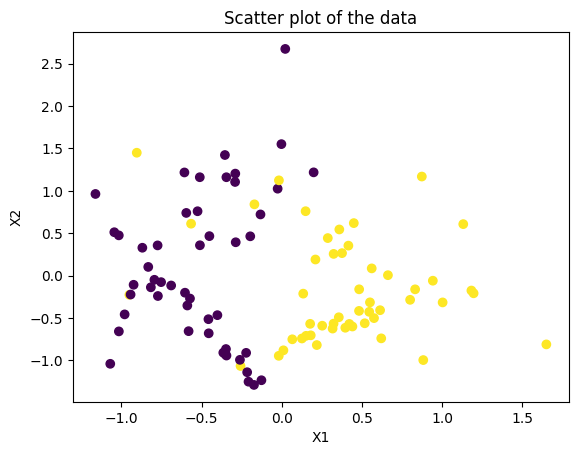

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tree.base import DecisionTree
from metrics import *
from sklearn.datasets import make_classification

np.random.seed(42)

# Code given in the question
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=2, class_sep=0.5)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# For plotting
plt.title('Scatter plot of the data')
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()



Q2 a) Show the usage of your decision tree on the above dataset. The first 70% of the data should be used for training purposes and the remaining 30% for test purposes. Show the accuracy, per-class precision and recall of the decision tree you implemented on the test dataset. [0.5 mark]

In [2]:
X_df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
y_series = pd.Series(y)

# Splitting the data into training and testing data
split = int(0.7 * X.shape[0])
X_train, X_test = X_df.iloc[:split], X_df.iloc[split:]
y_train, y_test = y_series.iloc[:split], y_series.iloc[split:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (70, 2)
Shape of X_test: (30, 2)
Shape of y_train: (70,)
Shape of y_test: (30,)


In [3]:
# Training the model
model = DecisionTree(criterion='information_gain', max_depth=5)
model.fit(X_train, y_train)

# Predicting the values
y_pred = model.predict(X_test)

print("Criteria :", "Information Gain")
print("Accuracy :", accuracy(y_test, y_pred))
for cls in np.unique(y_test):
    print(f"Precision for class {cls} :", precision(y_test, y_pred, cls))
    print(f"Recall for class {cls} :", recall(y_test, y_pred, cls))

Criteria : Information Gain
Accuracy : 0.8666666666666667
Precision for class 0 : 0.75
Recall for class 0 : 0.9
Precision for class 1 : 0.9444444444444444
Recall for class 1 : 0.85


Q2 b) Use 5 fold cross-validation on the dataset. Using nested cross-validation find the optimum depth of the tree. [1 mark]

# graphs without y limit


Evaluating Outer Fold 1...


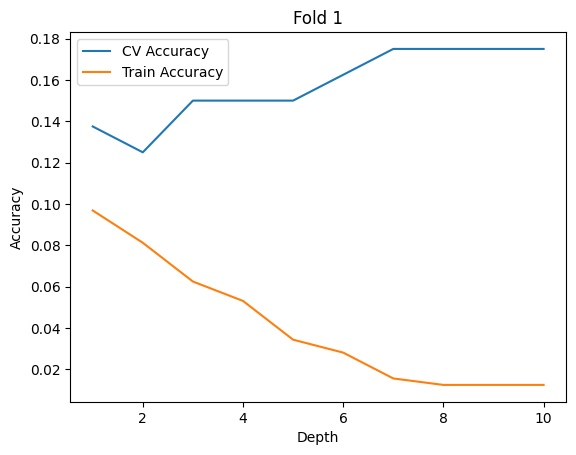


Results for Outer Fold 1:
  Best Depth Selected: 2
  Inner Cross-Validation Accuracy: 0.8750
  Outer Fold Training Accuracy: 0.9125
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------

Evaluating Outer Fold 2...


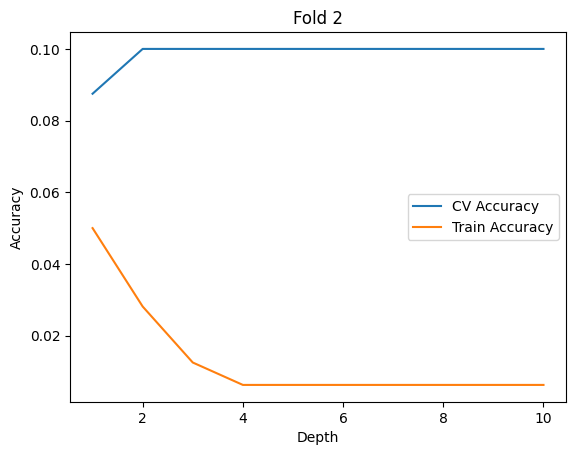


Results for Outer Fold 2:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.9125
  Outer Fold Training Accuracy: 0.9375
  Outer Fold Test Accuracy: 0.8000

--------------------------------------------------------------------------------

Evaluating Outer Fold 3...


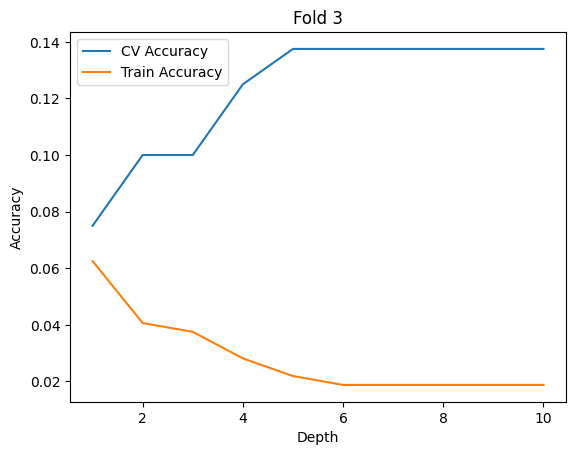


Results for Outer Fold 3:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.9250
  Outer Fold Training Accuracy: 0.9375
  Outer Fold Test Accuracy: 0.8500

--------------------------------------------------------------------------------

Evaluating Outer Fold 4...


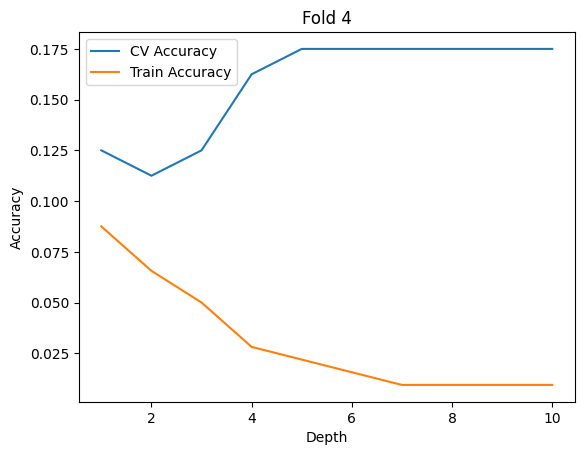


Results for Outer Fold 4:
  Best Depth Selected: 2
  Inner Cross-Validation Accuracy: 0.8875
  Outer Fold Training Accuracy: 0.9500
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------

Evaluating Outer Fold 5...


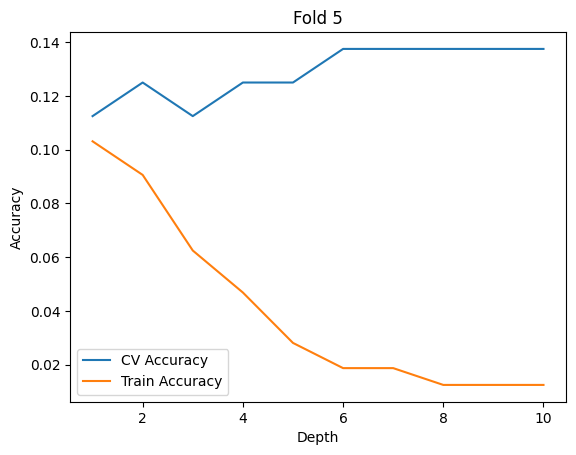


Results for Outer Fold 5:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.8875
  Outer Fold Training Accuracy: 0.9000
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Final Cross-Validation Results:
Best Depths Selected in Each Fold: [2, 1, 1, 2, 1]
Mean Training Accuracy Across Folds: 0.9275
Mean Test Accuracy Across Folds: 0.9000
Most Common Optimal Depth: 1


In [4]:
from sklearn.model_selection import KFold
import numpy as np

# Define depths to evaluate
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

best_depths = []
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Set up 5-fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Outer cross-validation loop
for fold, (train_index, test_index) in enumerate(outer_cv.split(X_df), 1):
    print(f"\nEvaluating Outer Fold {fold}...")

    # Split data into outer training and test sets
    X_outer_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_outer_train, y_test = y_series.iloc[train_index], y_series.iloc[test_index]

    best_inner_depth = None
    best_inner_score = -np.inf

    # Inner cross-validation loop to find the best depth
    depth_wise_cv_errors = []
    depth_wise_train_errors = []

    for depth in depths:
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        inner_train_scores = []
        inner_cv_scores = []

        for inner_train_index, inner_test_index in inner_cv.split(X_outer_train):
            X_inner_train, X_cv = X_outer_train.iloc[inner_train_index], X_outer_train.iloc[inner_test_index]
            y_inner_train, y_cv = y_outer_train.iloc[inner_train_index], y_outer_train.iloc[inner_test_index]

            # Train model on the inner training set with current depth
            model = DecisionTree(criterion='information_gain', max_depth=depth)
            model.fit(X_inner_train, y_inner_train)

            # Evaluate on inner training set
            y_inner_train_pred = model.predict(X_inner_train)
            inner_train_scores.append(accuracy(y_inner_train, y_inner_train_pred))

            # Evaluate on inner validation set
            y_cv_pred = model.predict(X_cv)
            inner_cv_scores.append(accuracy(y_cv, y_cv_pred))

        # Calculate the mean inner CV score for this depth
        mean_inner_cv_score = np.mean(inner_cv_scores)
        mean_inner_train_score = np.mean(inner_train_scores)
        # print(f"  Depth {depth}: Mean Inner CV Accuracy = {mean_inner_cv_score:.4f}")

        depth_wise_cv_errors.append(1 - mean_inner_cv_score)
        depth_wise_train_errors.append(1 - mean_inner_train_score)

        # Track the best depth for the current outer fold
        if mean_inner_cv_score > best_inner_score:
            best_inner_score = mean_inner_cv_score
            best_inner_depth = depth
        
    # plot the graph
    plt.figure()
    plt.plot(depths, depth_wise_cv_errors, label='CV Accuracy')
    plt.plot(depths, depth_wise_train_errors, label='Train Accuracy')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.title(f'Fold {fold}')
    plt.legend()
    plt.show()

    # Append the best depth for this outer fold
    best_depths.append(best_inner_depth)
    cv_accuracies.append(best_inner_score)

    # Train the model with the best depth on the outer training set
    model = DecisionTree(criterion='information_gain', max_depth=best_inner_depth)
    model.fit(X_outer_train, y_outer_train)

    # Evaluate on the outer training set
    y_outer_train_pred = model.predict(X_outer_train)
    train_accuracy = accuracy(y_outer_train, y_outer_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on the outer test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    # Print results for the current fold
    print(f"\nResults for Outer Fold {fold}:")
    print(f"  Best Depth Selected: {best_inner_depth}")
    print(f"  Inner Cross-Validation Accuracy: {best_inner_score:.4f}")
    print(f"  Outer Fold Training Accuracy: {train_accuracy:.4f}")
    print(f"  Outer Fold Test Accuracy: {test_accuracy:.4f}\n")
    print("-" * 80)

# Final summary of results across all outer folds
print("-" * 80)
print("\nFinal Cross-Validation Results:")
print(f"Best Depths Selected in Each Fold: {best_depths}")
print(f"Mean Training Accuracy Across Folds: {np.mean(train_accuracies):.4f}")
print(f"Mean Test Accuracy Across Folds: {np.mean(test_accuracies):.4f}")
print(f"Most Common Optimal Depth: {max(set(best_depths), key=best_depths.count)}")


# graphs with y limit


Evaluating Outer Fold 1...


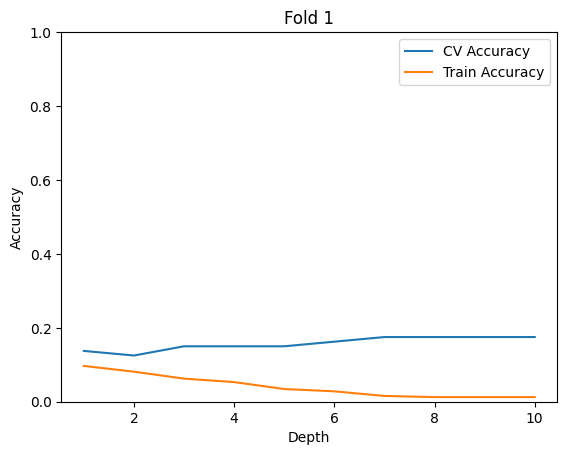


Results for Outer Fold 1:
  Best Depth Selected: 2
  Inner Cross-Validation Accuracy: 0.8750
  Outer Fold Training Accuracy: 0.9125
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------

Evaluating Outer Fold 2...


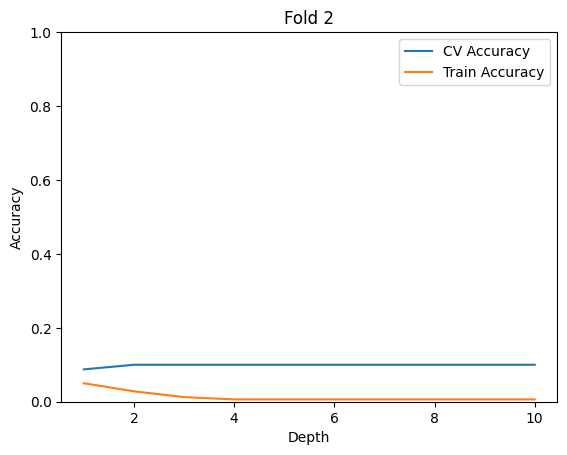


Results for Outer Fold 2:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.9125
  Outer Fold Training Accuracy: 0.9375
  Outer Fold Test Accuracy: 0.8000

--------------------------------------------------------------------------------

Evaluating Outer Fold 3...


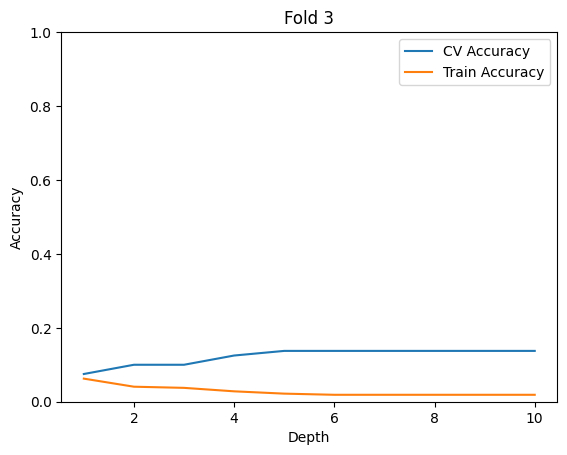


Results for Outer Fold 3:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.9250
  Outer Fold Training Accuracy: 0.9375
  Outer Fold Test Accuracy: 0.8500

--------------------------------------------------------------------------------

Evaluating Outer Fold 4...


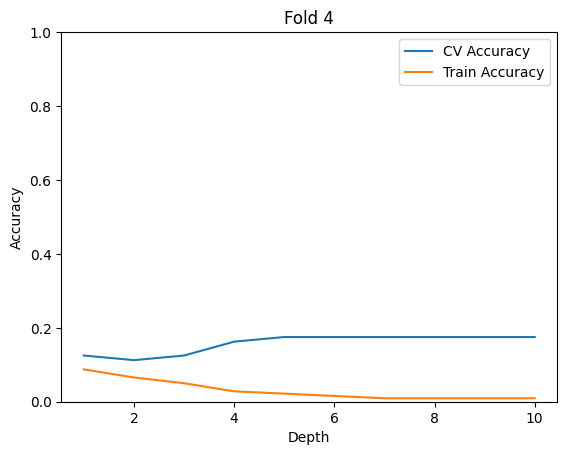


Results for Outer Fold 4:
  Best Depth Selected: 2
  Inner Cross-Validation Accuracy: 0.8875
  Outer Fold Training Accuracy: 0.9500
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------

Evaluating Outer Fold 5...


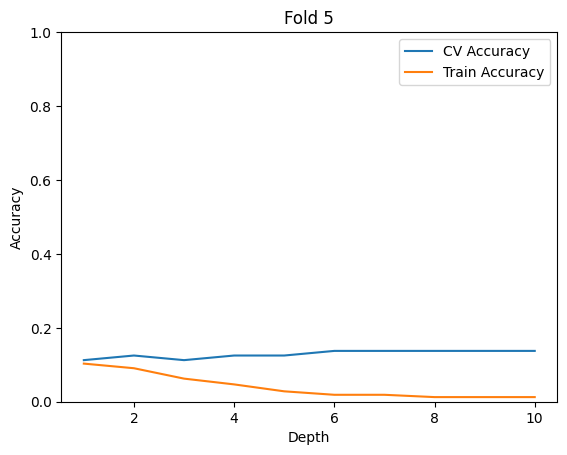


Results for Outer Fold 5:
  Best Depth Selected: 1
  Inner Cross-Validation Accuracy: 0.8875
  Outer Fold Training Accuracy: 0.9000
  Outer Fold Test Accuracy: 0.9500

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

Final Cross-Validation Results:
Best Depths Selected in Each Fold: [2, 1, 1, 2, 1]
Mean Training Accuracy Across Folds: 0.9275
Mean Test Accuracy Across Folds: 0.9000
Most Common Optimal Depth: 1


In [5]:
from sklearn.model_selection import KFold
import numpy as np

# Define depths to evaluate
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

best_depths = []
train_accuracies = []
test_accuracies = []
cv_accuracies = []

# Set up 5-fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Outer cross-validation loop
for fold, (train_index, test_index) in enumerate(outer_cv.split(X_df), 1):
    print(f"\nEvaluating Outer Fold {fold}...")

    # Split data into outer training and test sets
    X_outer_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_outer_train, y_test = y_series.iloc[train_index], y_series.iloc[test_index]

    best_inner_depth = None
    best_inner_score = -np.inf

    # Inner cross-validation loop to find the best depth
    depth_wise_cv_errors = []
    depth_wise_train_errors = []

    for depth in depths:
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
        inner_train_scores = []
        inner_cv_scores = []

        for inner_train_index, inner_test_index in inner_cv.split(X_outer_train):
            X_inner_train, X_cv = X_outer_train.iloc[inner_train_index], X_outer_train.iloc[inner_test_index]
            y_inner_train, y_cv = y_outer_train.iloc[inner_train_index], y_outer_train.iloc[inner_test_index]

            # Train model on the inner training set with current depth
            model = DecisionTree(criterion='information_gain', max_depth=depth)
            model.fit(X_inner_train, y_inner_train)

            # Evaluate on inner training set
            y_inner_train_pred = model.predict(X_inner_train)
            inner_train_scores.append(accuracy(y_inner_train, y_inner_train_pred))

            # Evaluate on inner validation set
            y_cv_pred = model.predict(X_cv)
            inner_cv_scores.append(accuracy(y_cv, y_cv_pred))

        # Calculate the mean inner CV score for this depth
        mean_inner_cv_score = np.mean(inner_cv_scores)
        mean_inner_train_score = np.mean(inner_train_scores)
        # print(f"  Depth {depth}: Mean Inner CV Accuracy = {mean_inner_cv_score:.4f}")

        depth_wise_cv_errors.append(1 - mean_inner_cv_score)
        depth_wise_train_errors.append(1 - mean_inner_train_score)

        # Track the best depth for the current outer fold
        if mean_inner_cv_score > best_inner_score:
            best_inner_score = mean_inner_cv_score
            best_inner_depth = depth
        
    # plot the graph
    plt.figure()
    plt.plot(depths, depth_wise_cv_errors, label='CV Accuracy')
    plt.plot(depths, depth_wise_train_errors, label='Train Accuracy')
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title(f'Fold {fold}')
    plt.legend()
    plt.show()

    # Append the best depth for this outer fold
    best_depths.append(best_inner_depth)
    cv_accuracies.append(best_inner_score)

    # Train the model with the best depth on the outer training set
    model = DecisionTree(criterion='information_gain', max_depth=best_inner_depth)
    model.fit(X_outer_train, y_outer_train)

    # Evaluate on the outer training set
    y_outer_train_pred = model.predict(X_outer_train)
    train_accuracy = accuracy(y_outer_train, y_outer_train_pred)
    train_accuracies.append(train_accuracy)

    # Evaluate on the outer test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy(y_test, y_test_pred)
    test_accuracies.append(test_accuracy)

    # Print results for the current fold
    print(f"\nResults for Outer Fold {fold}:")
    print(f"  Best Depth Selected: {best_inner_depth}")
    print(f"  Inner Cross-Validation Accuracy: {best_inner_score:.4f}")
    print(f"  Outer Fold Training Accuracy: {train_accuracy:.4f}")
    print(f"  Outer Fold Test Accuracy: {test_accuracy:.4f}\n")
    print("-" * 80)

# Final summary of results across all outer folds
print("-" * 80)
print("\nFinal Cross-Validation Results:")
print(f"Best Depths Selected in Each Fold: {best_depths}")
print(f"Mean Training Accuracy Across Folds: {np.mean(train_accuracies):.4f}")
print(f"Mean Test Accuracy Across Folds: {np.mean(test_accuracies):.4f}")
print(f"Most Common Optimal Depth: {max(set(best_depths), key=best_depths.count)}")
